# This code loads main screen data, assign cells to guides, and create the object Rd3_Data_post_sgRNA_rescue-reseq.h5ad

### Note that as a second dataset failed, we refer to Rd3 as the 'round 3' data

In [ ]:
import pandas as pd
from pathlib import Path
import json

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import re
import dask.dataframe as dd
import anndata as ad
from anndata import AnnData
#import relation_data_lake as rdl
import scipy.sparse as sp
import scanpy as sc

/opt/tljh/user/envs/jake_sc_eda/lib/python3.10/site-packages/anndata/experimental/pytorch/_annloader.py:18: UserWarning: Сould not load pytorch.
  warnings.warn("Сould not load pytorch.")


In [4]:
sns.set(rc={'figure.figsize':(11.7,8.27)})


In [5]:
local_root_dir = Path('/home/jupyter-jake/SharedData/collaborations/lara-fibroblast-mouse/reseqFibro2/')
fibro_processed_folders=[
    'exVivo_OP2_IL1b_1/outs',
    'exVivo_OP2_IL1b_2/outs',
    'exVivo_OP2_resting_1/outs',
    'exVivo_OP2_resting_2/outs',
    'exVivo_OP2_TGFb_1/outs',
    'exVivo_OP2_TGFb_2/outs',
]

In [6]:
cell2guides = []
for fibro_processed_folder in fibro_processed_folders:
    f_path = (local_root_dir / fibro_processed_folder / 'crispr_analysis/protospacer_calls_per_cell.csv')
    cell2guide = pd.read_csv(f_path, index_col='cell_barcode').drop(columns = ['num_features'])
    cell2guide = cell2guide.apply(lambda col: col.str.split('|'))
    cell2guide = cell2guide.apply(pd.Series.explode)
    cell2guide = cell2guide.pivot(columns='feature_call', values='num_umis').fillna(0)
    cell2guide.index = cell2guide.index + '-' + fibro_processed_folder.split('/')[0]
    #print(cell2guide.columns)
    cell2guides.append(cell2guide)

In [7]:
cell2guides = pd.concat(cell2guides) # .astype(int)
cell2guides[pd.isna(cell2guides)] = 0
cell2guides = cell2guides.astype(int)
counts_matrix = cell2guides.copy()

# Step 1: Filter low expressed counts that represent only a small fraction of total counts.

In [8]:
freq_matrix = counts_matrix / counts_matrix.sum(axis=1).values[:,None] 
log_freq_matrix = np.log10( 1 + counts_matrix ) / np.log10(1 + counts_matrix.sum(axis=1).values[:,None] ) 

df = pd.DataFrame(data={'cell_id':np.tile(counts_matrix.index,(1,counts_matrix.shape[1])).flatten(),
                        'total_counts': np.tile(counts_matrix.sum(axis=1),(1,counts_matrix.shape[1])).flatten(),
                        'log_total_counts': np.log10( np.tile(counts_matrix.sum(axis=1),(1,counts_matrix.shape[1])).flatten() ),
                        'freq': np.ravel(freq_matrix.values.T),
                        'log_freq': np.ravel(log_freq_matrix.values.T),
                        'sgRNA_counts': np.ravel(counts_matrix.values.T),
                        'log_sgRNA_counts': np.log10( np.ravel(counts_matrix.values.T) ) 
                       })
df

/tmp/ipykernel_2555936/5835236.py:10: RuntimeWarning: divide by zero encountered in log10
  'log_sgRNA_counts': np.log10( np.ravel(counts_matrix.values.T) )


,cell_id,total_counts,log_total_counts,freq,log_freq,sgRNA_counts,log_sgRNA_counts
0,AAACCCAAGCAGCGAT-1-exVivo_OP2_IL1b_1,290,2.462398,0.0,0.0,0,-inf
1,AAACCCAAGCGTCTGC-1-exVivo_OP2_IL1b_1,1909,3.280806,0.0,0.0,0,-inf
2,AAACCCACAAGCGCTC-1-exVivo_OP2_IL1b_1,30,1.477121,0.0,0.0,0,-inf
3,AAACCCACAAGTTCGT-1-exVivo_OP2_IL1b_1,159,2.201397,0.0,0.0,0,-inf
4,AAACCCATCATGCCAA-1-exVivo_OP2_IL1b_1,281,2.448706,0.0,0.0,0,-inf
...,...,...,...,...,...,...,...
1339555,TTTCATGTCCGATCTC-1-exVivo_OP2_TGFb_2,24,1.380211,0.0,0.0,0,-inf
1339556,TTTCCTCTCTGCGAGC-1-exVivo_OP2_TGFb_2,533,2.726727,0.0,0.0,0,-inf
1339557,TTTGACTAGGGATCAC-1-exVivo_OP2_TGFb_2,1002,3.000868,0.0,0.0,0,-inf
1339558,TTTGGTTGTAGGAAAG-1-exVivo_OP2_TGFb_2,2428,3.385249,0.0,0.0,0,-inf


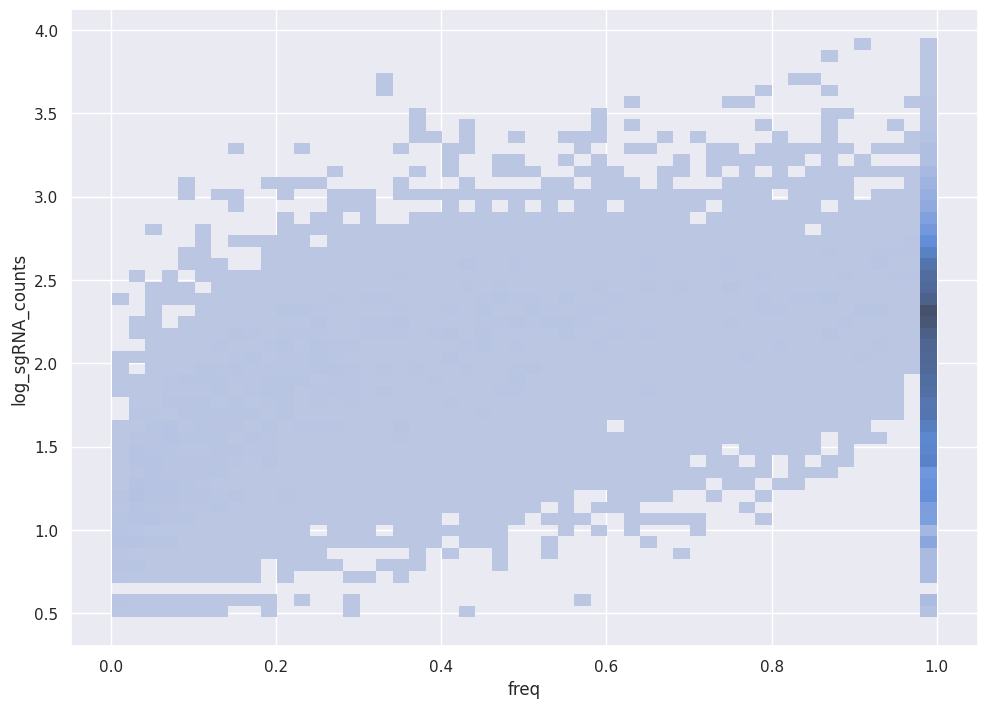

<Figure size 1170x827 with 0 Axes>

In [9]:
sns.histplot(
    data=df[df.log_sgRNA_counts > 0], x = 'freq', y = 'log_sgRNA_counts', bins=50
)

plt.savefig("figures/sgRNA_density_plot_Rd3", dpi=400)
plt.show()
plt.clf()

In [10]:
counts_matrix_filtered = counts_matrix.copy()
counts_matrix_filtered[(freq_matrix <= 0.175) & (counts_matrix <= 10**1.75)] = 0

In [11]:
freq_matrix = counts_matrix_filtered / counts_matrix_filtered.sum(axis=1).values[:,None] 
log_freq_matrix = np.log10( 1 + counts_matrix_filtered ) / np.log10(1 + counts_matrix_filtered.sum(axis=1).values[:,None] ) 

df = pd.DataFrame(data={'cell_id':np.tile(counts_matrix_filtered.index,(1,counts_matrix.shape[1])).flatten(),
                        'total_counts': np.tile(counts_matrix_filtered.sum(axis=1),(1,counts_matrix.shape[1])).flatten(),
                        'log_total_counts': np.log10( np.tile(counts_matrix_filtered.sum(axis=1),(1,counts_matrix.shape[1])).flatten() ),
                        'freq': np.ravel(freq_matrix.values.T),
                        'log_freq': np.ravel(log_freq_matrix.values.T),
                        'sgRNA_counts': np.ravel(counts_matrix_filtered.values.T),
                        'log_sgRNA_counts': np.log10( np.ravel(counts_matrix_filtered.values.T) ) 
                       })

/tmp/ipykernel_2555936/1625252562.py:10: RuntimeWarning: divide by zero encountered in log10
  'log_sgRNA_counts': np.log10( np.ravel(counts_matrix_filtered.values.T) )


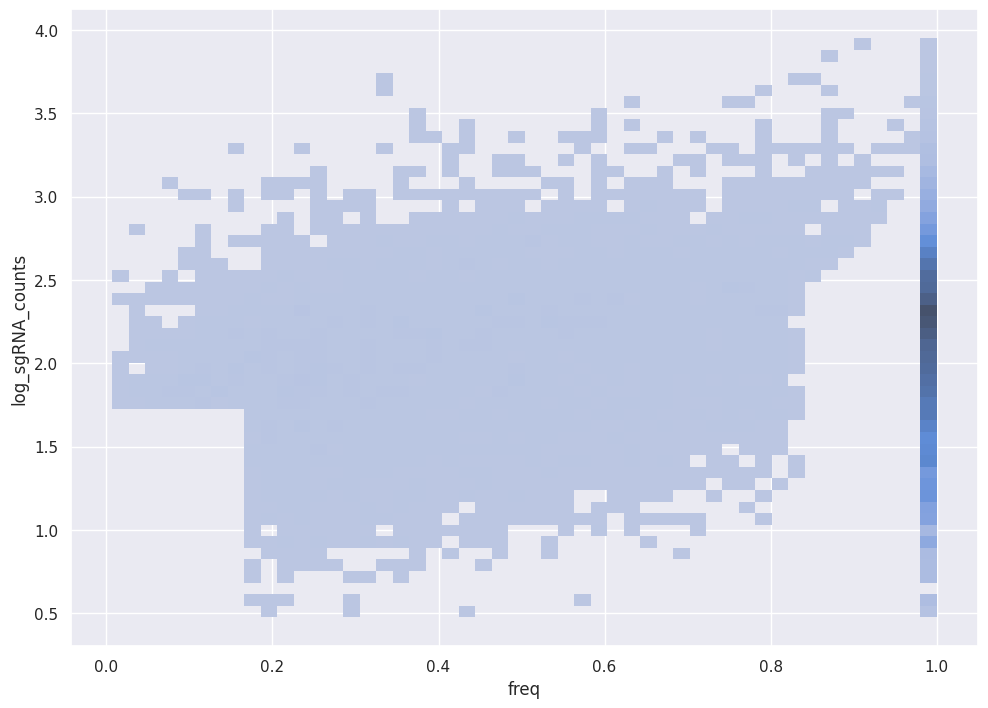

<Figure size 1170x827 with 0 Axes>

In [12]:
sns.histplot(
    data=df[df.log_sgRNA_counts > 0], x = 'freq', y = 'log_sgRNA_counts', bins=50
)

plt.savefig("figures/sgRNA_density_plot_filtered_Rd3", dpi=400)
plt.show()
plt.clf()

# Step 2: Map MOI=2 cells to MOI=1 when sgRNAs correspond to same gene, or with a targeting gene & NTC

In [13]:
def combine_columns_and_delete(counts_matrix_filtered, col1, col2, new_col):
    counts_matrix_filtered[new_col] = counts_matrix_filtered[col1] + counts_matrix_filtered[col2]
    counts_matrix_filtered = counts_matrix_filtered.drop(columns=[col1, col2])
    return counts_matrix_filtered

In [14]:
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'NTC_0005','NTC_0006','non-targeting')


In [15]:
counts_matrix_filtered.columns

Index(['Arid2_As_73066', 'Arid2_As_73067', 'Brd7_As_70314', 'Brd7_As_70316',
       'Brd9_As_70306', 'Brd9_As_70308', 'Chd4_As_66308', 'Chd4_As_66309',
       'Dmap1_As_60920', 'Dmap1_As_60922', 'EGR2_2', 'EGR2_3',
       'Hcfc1_As_49709', 'Hcfc1_As_49711', 'Ino80_As_46860', 'Ino80_As_46861',
       'Kansl1_As_45908', 'Kansl1_As_45909', 'Kat5_Br_45092', 'Kat5_Br_45093',
       'Kat8_As_45860', 'Kat8_As_45861', 'Kmt2a_As_44476', 'Kmt2a_Br_53969',
       'Paxip1_As_28665', 'Paxip1_As_28666', 'Pbrm1_As_28642',
       'Pbrm1_As_28643', 'Rest_As_21510', 'Rest_As_21511', 'Rnf40_As_20441',
       'Rnf40_As_20442', 'Setd1b_As_17785', 'Setd1b_Br_52333',
       'Setdb1_B_17753', 'Setdb1_B_17754', 'Smad2_1', 'Smad2_2', 'Smad3_1',
       'Smad4_1', 'Smarca4_As_15193', 'Smarca4_As_15194', 'Smarcd1_As_15167',
       'Smarcd1_Br_45407', 'Srcap_As_77988', 'Srcap_As_77989', 'TGFbR_1',
       'TGFbR_3', 'Tfpt_As_10465', 'Tfpt_As_10466', 'Wdr82_As_3096',
       'Wdr82_As_3097', 'Yeats4_As_2486', 'Yeats4_

In [16]:
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Arid2_As_73066', 'Arid2_As_73067','Arid2')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Brd7_As_70314', 'Brd7_As_70316','Brd7')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Brd9_As_70306', 'Brd9_As_70308','Brd9')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Hcfc1_As_49709', 'Hcfc1_As_49711','Hcfc1')

counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Kansl1_As_45908', 'Kansl1_As_45909','Kansl1')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Kat5_Br_45092', 'Kat5_Br_45093','Kat5')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Kat8_As_45860', 'Kat8_As_45861','Kat8')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered, 'Pbrm1_As_28642', 'Pbrm1_As_28643','Pbrm1')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Smarcd1_As_15167', 'Smarcd1_Br_45407','Smarcd1')

counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Wdr82_As_3096', 'Wdr82_As_3097','Wdr82')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Chd4_As_66308','Chd4_As_66309','Chd4')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'EGR2_2', 'EGR2_3','Egr2')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Kmt2a_As_44476','Kmt2a_Br_53969','Kmt2a')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Paxip1_As_28665', 'Paxip1_As_28666','Paxip1')

counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Rest_As_21510', 'Rest_As_21511','Rest')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Rnf40_As_20441','Rnf40_As_20442','Rnf40')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Setd1b_As_17785', 'Setd1b_Br_52333','Setd1b')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered, 'Setdb1_B_17753', 'Setdb1_B_17754','Setdb1')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Smad2_1', 'Smad2_2','Smad2')

counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Smarca4_As_15193', 'Smarca4_As_15194','Smarca4')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Tfpt_As_10465', 'Tfpt_As_10466','Tfpt')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Yeats4_As_2486', 'Yeats4_As_2487','Yeats4')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Dmap1_As_60920', 'Dmap1_As_60922','Dmap1')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Ino80_As_46860', 'Ino80_As_46861','Ino80')

counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Srcap_As_77988', 'Srcap_As_77989','Srcap')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Yy1_As_2358', 'Yy1_As_2359','Yy1')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Znhit1_As_220', 'Znhit1_As_222','Znhit1')

counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Smad4_3', 'Smad4_1','Smad4')

counts_matrix_filtered = counts_matrix_filtered.rename(columns={"Smad3_1":"Smad3"})




counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'TGFbR_3', 'TGFbR_1','Tgfbr1')
counts_matrix_filtered = counts_matrix_filtered.rename(columns={'TGFbR_1':'Tgfbr1'})



In [17]:
counts_matrix_filtered

feature_call,Smad3,non-targeting,Arid2,Brd7,Brd9,Hcfc1,Kansl1,Kat5,Kat8,Pbrm1,...,Smarca4,Tfpt,Yeats4,Dmap1,Ino80,Srcap,Yy1,Znhit1,Smad4,Tgfbr1
cell_barcode,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGCAGCGAT-1-exVivo_OP2_IL1b_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCCAAGCGTCTGC-1-exVivo_OP2_IL1b_1,0,0,0,1909,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCCACAAGCGCTC-1-exVivo_OP2_IL1b_1,0,0,0,0,0,0,0,0,0,0,...,0,0,30,0,0,0,0,0,0,0
AAACCCACAAGTTCGT-1-exVivo_OP2_IL1b_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCCATCATGCCAA-1-exVivo_OP2_IL1b_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCATGTCCGATCTC-1-exVivo_OP2_TGFb_2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TTTCCTCTCTGCGAGC-1-exVivo_OP2_TGFb_2,0,0,0,443,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TTTGACTAGGGATCAC-1-exVivo_OP2_TGFb_2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
counts_matrix_filtered.sum()

feature_call
Smad3            189222
non-targeting    199487
Arid2            121027
Brd7             453785
Brd9             134723
Hcfc1             98646
Kansl1            88643
Kat5             211940
Kat8             187984
Pbrm1            354042
Smarcd1          279245
Wdr82             76360
Chd4             114607
Egr2             305389
Kmt2a            244150
Paxip1           215062
Rest             519100
Rnf40            106003
Setd1b           212457
Setdb1           517062
Smad2            194297
Smarca4          156775
Tfpt             124085
Yeats4            68392
Dmap1             18133
Ino80             93534
Srcap             76428
Yy1              119566
Znhit1           369529
Smad4            126882
Tgfbr1           105170
dtype: int64

In [19]:
counts_matrix_filtered.columns

Index(['Smad3', 'non-targeting', 'Arid2', 'Brd7', 'Brd9', 'Hcfc1', 'Kansl1',
       'Kat5', 'Kat8', 'Pbrm1', 'Smarcd1', 'Wdr82', 'Chd4', 'Egr2', 'Kmt2a',
       'Paxip1', 'Rest', 'Rnf40', 'Setd1b', 'Setdb1', 'Smad2', 'Smarca4',
       'Tfpt', 'Yeats4', 'Dmap1', 'Ino80', 'Srcap', 'Yy1', 'Znhit1', 'Smad4',
       'Tgfbr1'],
      dtype='object', name='feature_call')

In [20]:
MOI1_cells = counts_matrix_filtered[(counts_matrix_filtered >0).apply(lambda row: sum(row)==1, axis=1)]
MOI2_cells = counts_matrix_filtered[(counts_matrix_filtered >0).apply(lambda row: sum(row)==2, axis=1)]

In [21]:
MOI2_cells['non-targeting'] = 0
MOI1_rescue = MOI2_cells[(MOI2_cells >0).apply(lambda row: sum(row)==1, axis=1)]

/tmp/ipykernel_2555936/2051351486.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MOI2_cells['non-targeting'] = 0


In [22]:
cells_to_keep = pd.concat([MOI1_cells, MOI1_rescue])
cells_to_keep['target_max'] = cells_to_keep.idxmax(axis=1)
cells_to_keep = cells_to_keep.drop(columns=counts_matrix_filtered.columns.unique())


In [23]:
cells_to_keep

feature_call,target_max
cell_barcode,
AAACCCAAGCAGCGAT-1-exVivo_OP2_IL1b_1,Kmt2a
AAACCCAAGCGTCTGC-1-exVivo_OP2_IL1b_1,Brd7
AAACCCACAAGCGCTC-1-exVivo_OP2_IL1b_1,Yeats4
AAACCCACAAGTTCGT-1-exVivo_OP2_IL1b_1,Egr2
AAACCCATCATGCCAA-1-exVivo_OP2_IL1b_1,Setd1b
...,...
GTCGTTCGTTATGTCG-1-exVivo_OP2_TGFb_2,Brd9
GTGGAAGGTCCGGTGT-1-exVivo_OP2_TGFb_2,Setdb1
TCGTGCTAGTTACTCG-1-exVivo_OP2_TGFb_2,Egr2


In [24]:
cells_to_keep['cell_barcode_corrected'] = 0
cells_to_keep['cell_barcode_old'] = cells_to_keep.index
cells_to_keep['condition'] = 'NaN'
cells_to_keep['batch'] = 'NaN'
for cb in cells_to_keep.index:    
    if 'resting' in cb:
        state1 = 'Resting'
        if 'resting_1' in cb:
            state2 = 'Rep5-Resting'
        else:
            state2 = 'Rep6-Resting'  
    if 'TGFb' in cb:
        state1 = 'Tgfb1'
        if 'TGFb_1' in cb:
            state2 = 'Rep7-Tgfb1'
        else:
            state2 = 'Rep8-Tgfb1'
    if 'IL1b' in cb:
        state1 = 'Il1b'
        if 'IL1b_1' in cb:
            state2 = 'Rep9-Il1b'
        else:
            state2 = 'Rep10-Il1b'   
    cells_to_keep['condition'].loc[cb] = state1
    cells_to_keep['batch'].loc[cb] = state2
    cells_to_keep['cell_barcode_corrected'].loc[cb] = cb[0:16] + '-' + state2
    cells_to_keep['cell_barcode_old'].loc[cb] = cb[0:18]
cells_to_keep = cells_to_keep.set_index('cell_barcode_corrected')


/tmp/ipykernel_2555936/3038748056.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cells_to_keep['condition'].loc[cb] = state1
/tmp/ipykernel_2555936/3038748056.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cells_to_keep['batch'].loc[cb] = state2
/tmp/ipykernel_2555936/3038748056.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cells_to_keep['cell_barcode_corrected'].loc[cb] = cb[0:16] + '-' + state2


In [25]:
cells_to_keep.batch.unique()

array(['Rep9-Il1b', 'Rep10-Il1b', 'Rep5-Resting', 'Rep6-Resting',
       'Rep7-Tgfb1', 'Rep8-Tgfb1'], dtype=object)

In [26]:
cells_to_keep.groupby(['batch']).count()

feature_call,target_max,cell_barcode_old,condition
batch,,,
Rep10-Il1b,3811,3811,3811
Rep5-Resting,3235,3235,3235
Rep6-Resting,3590,3590,3590
Rep7-Tgfb1,3784,3784,3784
Rep8-Tgfb1,861,861,861
Rep9-Il1b,3826,3826,3826


# Step 3: Select cells and merge into adata object

In [27]:
adata_rep5 = sc.read_10x_h5('/home/jupyter-jake/SharedData/collaborations/lara-fibroblast-mouse/reseqFibro2/exVivo_OP2_resting_1/outs/filtered_feature_bc_matrix.h5')
adata_rep6 = sc.read_10x_h5('/home/jupyter-jake/SharedData/collaborations/lara-fibroblast-mouse/reseqFibro2/exVivo_OP2_resting_2/outs/filtered_feature_bc_matrix.h5')
adata_rep7 = sc.read_10x_h5('/home/jupyter-jake/SharedData/collaborations/lara-fibroblast-mouse/reseqFibro2/exVivo_OP2_TGFb_1/outs/filtered_feature_bc_matrix.h5')
adata_rep8 = sc.read_10x_h5('/home/jupyter-jake/SharedData/collaborations/lara-fibroblast-mouse/reseqFibro2/exVivo_OP2_TGFb_2/outs/filtered_feature_bc_matrix.h5')
adata_rep9 = sc.read_10x_h5('/home/jupyter-jake/SharedData/collaborations/lara-fibroblast-mouse/reseqFibro2/exVivo_OP2_IL1b_1/outs/filtered_feature_bc_matrix.h5')
adata_rep10 = sc.read_10x_h5('/home/jupyter-jake/SharedData/collaborations/lara-fibroblast-mouse/reseqFibro2/exVivo_OP2_IL1b_2/outs/filtered_feature_bc_matrix.h5')

/opt/tljh/user/envs/jake_sc_eda/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/tljh/user/envs/jake_sc_eda/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/tljh/user/envs/jake_sc_eda/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/tljh/user/envs/jake_sc_eda/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/tljh/user/envs/jake_sc_eda/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarn

In [28]:
batch_adatas = {'Rep5-Resting':adata_rep5,
                'Rep6-Resting':adata_rep6, 
                'Rep7-Tgfb1':adata_rep7, 
                'Rep8-Tgfb1':adata_rep8, 
                'Rep9-Il1b':adata_rep9, 
                'Rep10-Il1b':adata_rep10}

In [29]:
for ii in batch_adatas.keys():
    print(ii)
    adata_tmp = batch_adatas[ii].copy()
    cells_to_keep_tmp = cells_to_keep[cells_to_keep.batch == ii].copy()
    cells_to_keep_tmp.reset_index(inplace=True)
    cells_to_keep_tmp.set_index('cell_barcode_old', inplace=True)
    adata_tmp = adata_tmp[adata_tmp.obs.index.isin(cells_to_keep_tmp.index),:]
    adata_tmp.obs = pd.concat([adata_tmp.obs, cells_to_keep_tmp], axis=1).reindex(adata_tmp.obs.index)
    adata_tmp.obs.set_index('cell_barcode_corrected', inplace=True)
    adata_tmp.var.index.name = 'original_name'
    adata_tmp.obs_names_make_unique()
    adata_tmp.var_names_make_unique()
    batch_adatas[ii] = adata_tmp

Rep5-Resting
Rep6-Resting
Rep7-Tgfb1
Rep8-Tgfb1


/opt/tljh/user/envs/jake_sc_eda/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/tljh/user/envs/jake_sc_eda/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/tljh/user/envs/jake_sc_eda/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/tljh/user/envs/jake_sc_eda/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/tljh/user/envs/jake_sc_eda/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarn

Rep9-Il1b
Rep10-Il1b


/opt/tljh/user/envs/jake_sc_eda/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/tljh/user/envs/jake_sc_eda/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/tljh/user/envs/jake_sc_eda/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [30]:
adata = ad.concat(batch_adatas, axis = 0)

In [31]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'

In [32]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [33]:
adata.obs['target'] = adata.obs['target_max']
adata.obs.drop(columns=['target_max'], inplace=True)

In [34]:
adata.obs.groupby(['condition','batch']).count()

n_genes_by_counts  total_counts  total_counts_mt  \
condition batch                                                            
Il1b      Rep10-Il1b                 3811          3811             3811   
          Rep9-Il1b                  3826          3826             3826   
Resting   Rep5-Resting               3235          3235             3235   
          Rep6-Resting               3590          3590             3590   
Tgfb1     Rep7-Tgfb1                 3784          3784             3784   
          Rep8-Tgfb1                  861           861              861   

                        pct_counts_mt  target  
condition batch                                
Il1b      Rep10-Il1b             3811    3811  
          Rep9-Il1b              3826    3826  
Resting   Rep5-Resting           3235    3235  
          Rep6-Resting           3590    3590  
Tgfb1     Rep7-Tgfb1             3784    3784  
          Rep8-Tgfb1              861     861

In [35]:
adata.write_h5ad('../Rd3_Data_post_sgRNA_rescue-reseq.h5ad.gzip', compression='gzip')